# Model 2 (D+3)

Alexandre

Here is a research notebook used for tests on predictiv models.

### Import librairies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


Install the jupyter-tensorboard extension if needed:

https://github.com/lspvic/jupyter_tensorboard

In [2]:
#%pip install jupyter-tensorboard

Load Tensorboard:

In [3]:
%load_ext tensorboard

### Parameters:

In [4]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/completeDataset/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

### Import dataset and categorize the wind_direction:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

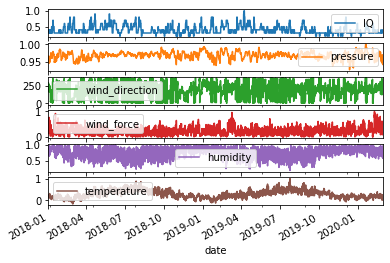

,IQ,pressure,wind_force,humidity,temperature,0,10,20,30,40,...,270,280,290,300,310,320,330,340,350,360
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.4,0.953970,0.652632,0.73,0.190821,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 03:00:00+00:00,0.4,0.956463,0.426316,0.84,0.149758,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 06:00:00+00:00,0.4,0.957518,0.394737,0.82,0.142512,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 09:00:00+00:00,0.4,0.956367,0.321053,0.84,0.135266,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 12:00:00+00:00,0.4,0.951669,0.357895,0.87,0.164251,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')
df['date'] = pd.to_datetime(df['date'],utc=True)

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(features,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['IQ'] = features['IQ'].apply(lambda x: x/10)
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

features.plot(subplots=True)
plt.show()

#wind_direction to categorical
features = pd.concat([features, pd.get_dummies(features['wind_direction'])], axis=1)
features = features.drop(columns=["wind_direction"])

features.head()

______________

### Create training data

#### Set the parameters:

In [6]:
#Params
nb_prev_measures_for_predict = 16 # = N in the following explanation

#### Create the train dataset: 
For each day we want to make a prediction of the air quality based on the N previous observation, sarting from the one at 12:00 of this day.

In [7]:
x_train = []
y_train = []
countRow=0

for indexRow, rowx in features.iterrows():
    # for each day we found with a value at 12:00
    if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
        try:
            # indexes for x (the range is inversed as our data are from the oldest to the newest)
            batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
            # indexes for y
            batchY = [countRow+8,countRow+16,countRow+24]

            #application
            y_train.append(features.iloc[batchY]["IQ"].values)
            x_train.append(features.iloc[batchX].values)
        except:
            print("To long for ",indexRow)
    countRow+=1
    
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],3,1)
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

To long for  2020-02-27 12:00:00+00:00
To long for  2020-02-28 12:00:00+00:00
To long for  2020-02-29 12:00:00+00:00
x_train : (784, 16, 42)
y_train : (784, 3, 1)


____________________________________

### Load the model or create it:

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import LSTM, Dense, Input
from keras.models import save_model

In [9]:
OPTIMIZER = RMSprop(0.0005)

if LOAD_MODEL: 
    model = load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])
    inp = Input(input_shape)
    _ = LSTM(512,input_shape=input_shape,name='LSTM_layer')(inp)
    _ = Dense(128,name="Intermediate_dense_layer")(_)
    
    outD1 = Dense(1,name="D1")(_)
    outD2 = Dense(1,name="D2")(_)
    outD3 = Dense(1,name="D3")(_)
    
    model = Model(inputs=[inp], outputs=[outD1, outD2, outD3])
    
    model.compile(optimizer=OPTIMIZER, loss={'D1': 'mse', 'D2': 'mse', 'D3': 'mse'}, metrics={'D1': 'mae', 'D2': 'mae', 'D3': 'mae'})
    model.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 42)       0                                            
__________________________________________________________________________________________________
LSTM_layer (LSTM)               (None, 512)          1136640     input_1[0][0]                    
__________________________________________________________________________________________________
Intermediate_dense_layer (Dense (None, 128)          65664       LSTM_layer[0][0]                 
__________________________________________________________________________________________________
D1 (Dense)                      (None, 1)            129         Intermediate_dense_layer[0][0]   
__________________________________________________________________________________________________
D2 (De

### Train

In [10]:
EPOCHS = 40
kfoldsize = 5

callbackName = str('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
tensor_board = TensorBoard(callbackName)

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    hist = model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,callbacks = [tensor_board])
    save_model(model,"Models/model"+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+".h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 627 samples, validate on 157 samples


Epoch 1/40
627/627 [==============================] - 4s 6ms/step - loss: 0.1154 - D1_loss: 0.0460 - D2_loss: 0.0404 - D3_loss: 0.0290 - D1_mean_absolute_error: 0.1500 - D2_mean_absolute_error: 0.1450 - D3_mean_absolute_error: 0.1298 - val_loss: 0.0789 - val_D1_loss: 0.0357 - val_D2_loss: 0.0219 - val_D3_loss: 0.0213 - val_D1_mean_absolute_error: 0.1410 - val_D2_mean_absolute_error: 0.1123 - val_D3_mean_absolute_error: 0.1120
Epoch 2/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0571 - D1_loss: 0.0167 - D2_loss: 0.0200 - D3_loss: 0.0203 - D1_mean_absolute_error: 0.0996 - D2_mean_absolute_error: 0.1095 - D3_mean_absolute_error: 0.1098 - val_loss: 0.0791 - val_D1_loss: 0.0307 - val_D2_loss: 0.0230 - val_D3_loss: 0.0254 - val_D1_mean_absolute_error: 0.1317 - val_D2_mean_absolute_error: 0.1129 - val_D3_mean_absolute_error: 0.1

627/627 [==============================] - 3s 5ms/step - loss: 0.0325 - D1_loss: 0.0087 - D2_loss: 0.0115 - D3_loss: 0.0123 - D1_mean_absolute_error: 0.0703 - D2_mean_absolute_error: 0.0803 - D3_mean_absolute_error: 0.0833 - val_loss: 0.0889 - val_D1_loss: 0.0240 - val_D2_loss: 0.0313 - val_D3_loss: 0.0336 - val_D1_mean_absolute_error: 0.1152 - val_D2_mean_absolute_error: 0.1338 - val_D3_mean_absolute_error: 0.1432
Epoch 18/40
627/627 [==============================] - 3s 4ms/step - loss: 0.0343 - D1_loss: 0.0095 - D2_loss: 0.0121 - D3_loss: 0.0127 - D1_mean_absolute_error: 0.0729 - D2_mean_absolute_error: 0.0821 - D3_mean_absolute_error: 0.0859 - val_loss: 0.0604 - val_D1_loss: 0.0159 - val_D2_loss: 0.0223 - val_D3_loss: 0.0222 - val_D1_mean_absolute_error: 0.0948 - val_D2_mean_absolute_error: 0.1115 - val_D3_mean_absolute_error: 0.1197
Epoch 19/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0330 - D1_loss: 0.0085 - D2_loss: 0.0118 - D3_loss: 0.0128 - D1_mean_abso

627/627 [==============================] - 2s 3ms/step - loss: 0.0240 - D1_loss: 0.0066 - D2_loss: 0.0084 - D3_loss: 0.0090 - D1_mean_absolute_error: 0.0612 - D2_mean_absolute_error: 0.0687 - D3_mean_absolute_error: 0.0712 - val_loss: 0.0694 - val_D1_loss: 0.0171 - val_D2_loss: 0.0255 - val_D3_loss: 0.0268 - val_D1_mean_absolute_error: 0.0954 - val_D2_mean_absolute_error: 0.1222 - val_D3_mean_absolute_error: 0.1293
Epoch 37/40
627/627 [==============================] - 3s 5ms/step - loss: 0.0237 - D1_loss: 0.0066 - D2_loss: 0.0081 - D3_loss: 0.0091 - D1_mean_absolute_error: 0.0617 - D2_mean_absolute_error: 0.0685 - D3_mean_absolute_error: 0.0723 - val_loss: 0.0777 - val_D1_loss: 0.0192 - val_D2_loss: 0.0280 - val_D3_loss: 0.0305 - val_D1_mean_absolute_error: 0.1012 - val_D2_mean_absolute_error: 0.1215 - val_D3_mean_absolute_error: 0.1320
Epoch 38/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0246 - D1_loss: 0.0072 - D2_loss: 0.0081 - D3_loss: 0.0094 - D1_mean_abso

Epoch 15/40
627/627 [==============================] - 3s 4ms/step - loss: 0.0185 - D1_loss: 0.0054 - D2_loss: 0.0059 - D3_loss: 0.0072 - D1_mean_absolute_error: 0.0559 - D2_mean_absolute_error: 0.0602 - D3_mean_absolute_error: 0.0645 - val_loss: 0.0459 - val_D1_loss: 0.0138 - val_D2_loss: 0.0158 - val_D3_loss: 0.0162 - val_D1_mean_absolute_error: 0.0891 - val_D2_mean_absolute_error: 0.1056 - val_D3_mean_absolute_error: 0.0985
Epoch 16/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0200 - D1_loss: 0.0066 - D2_loss: 0.0063 - D3_loss: 0.0070 - D1_mean_absolute_error: 0.0615 - D2_mean_absolute_error: 0.0618 - D3_mean_absolute_error: 0.0637 - val_loss: 0.0352 - val_D1_loss: 0.0084 - val_D2_loss: 0.0119 - val_D3_loss: 0.0149 - val_D1_mean_absolute_error: 0.0720 - val_D2_mean_absolute_error: 0.0871 - val_D3_mean_absolute_error: 0.0946
Epoch 17/40
627/627 [==============================] - 3s 4ms/step - loss: 0.0172 - D1_loss: 0.0051 - D2_loss: 0.0051 - D3_loss: 0.0069 - 

627/627 [==============================] - 2s 4ms/step - loss: 0.0093 - D1_loss: 0.0030 - D2_loss: 0.0026 - D3_loss: 0.0036 - D1_mean_absolute_error: 0.0434 - D2_mean_absolute_error: 0.0400 - D3_mean_absolute_error: 0.0481 - val_loss: 0.0420 - val_D1_loss: 0.0092 - val_D2_loss: 0.0133 - val_D3_loss: 0.0196 - val_D1_mean_absolute_error: 0.0794 - val_D2_mean_absolute_error: 0.0942 - val_D3_mean_absolute_error: 0.1116
Epoch 35/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0097 - D1_loss: 0.0034 - D2_loss: 0.0029 - D3_loss: 0.0034 - D1_mean_absolute_error: 0.0460 - D2_mean_absolute_error: 0.0418 - D3_mean_absolute_error: 0.0464 - val_loss: 0.0391 - val_D1_loss: 0.0092 - val_D2_loss: 0.0143 - val_D3_loss: 0.0157 - val_D1_mean_absolute_error: 0.0760 - val_D2_mean_absolute_error: 0.0943 - val_D3_mean_absolute_error: 0.0968
Epoch 36/40
627/627 [==============================] - 3s 5ms/step - loss: 0.0088 - D1_loss: 0.0030 - D2_loss: 0.0027 - D3_loss: 0.0031 - D1_mean_abso

Epoch 13/40
627/627 [==============================] - 3s 5ms/step - loss: 0.0079 - D1_loss: 0.0024 - D2_loss: 0.0025 - D3_loss: 0.0029 - D1_mean_absolute_error: 0.0386 - D2_mean_absolute_error: 0.0382 - D3_mean_absolute_error: 0.0425 - val_loss: 0.0184 - val_D1_loss: 0.0058 - val_D2_loss: 0.0046 - val_D3_loss: 0.0081 - val_D1_mean_absolute_error: 0.0599 - val_D2_mean_absolute_error: 0.0518 - val_D3_mean_absolute_error: 0.0716
Epoch 14/40
627/627 [==============================] - 3s 5ms/step - loss: 0.0076 - D1_loss: 0.0026 - D2_loss: 0.0023 - D3_loss: 0.0026 - D1_mean_absolute_error: 0.0393 - D2_mean_absolute_error: 0.0379 - D3_mean_absolute_error: 0.0393 - val_loss: 0.0164 - val_D1_loss: 0.0050 - val_D2_loss: 0.0052 - val_D3_loss: 0.0063 - val_D1_mean_absolute_error: 0.0545 - val_D2_mean_absolute_error: 0.0571 - val_D3_mean_absolute_error: 0.0618
Epoch 15/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0064 - D1_loss: 0.0020 - D2_loss: 0.0017 - D3_loss: 0.0026 - 

627/627 [==============================] - 2s 3ms/step - loss: 0.0040 - D1_loss: 0.0014 - D2_loss: 0.0012 - D3_loss: 0.0013 - D1_mean_absolute_error: 0.0299 - D2_mean_absolute_error: 0.0267 - D3_mean_absolute_error: 0.0270 - val_loss: 0.0183 - val_D1_loss: 0.0062 - val_D2_loss: 0.0055 - val_D3_loss: 0.0067 - val_D1_mean_absolute_error: 0.0601 - val_D2_mean_absolute_error: 0.0551 - val_D3_mean_absolute_error: 0.0626
Epoch 33/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0044 - D1_loss: 0.0014 - D2_loss: 0.0014 - D3_loss: 0.0016 - D1_mean_absolute_error: 0.0290 - D2_mean_absolute_error: 0.0291 - D3_mean_absolute_error: 0.0312 - val_loss: 0.0178 - val_D1_loss: 0.0063 - val_D2_loss: 0.0056 - val_D3_loss: 0.0059 - val_D1_mean_absolute_error: 0.0623 - val_D2_mean_absolute_error: 0.0558 - val_D3_mean_absolute_error: 0.0611
Epoch 34/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0047 - D1_loss: 0.0017 - D2_loss: 0.0013 - D3_loss: 0.0017 - D1_mean_abso

Epoch 11/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0042 - D1_loss: 0.0012 - D2_loss: 0.0015 - D3_loss: 0.0016 - D1_mean_absolute_error: 0.0272 - D2_mean_absolute_error: 0.0293 - D3_mean_absolute_error: 0.0303 - val_loss: 0.0051 - val_D1_loss: 0.0016 - val_D2_loss: 0.0015 - val_D3_loss: 0.0020 - val_D1_mean_absolute_error: 0.0313 - val_D2_mean_absolute_error: 0.0312 - val_D3_mean_absolute_error: 0.0367
Epoch 12/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0039 - D1_loss: 0.0012 - D2_loss: 0.0011 - D3_loss: 0.0016 - D1_mean_absolute_error: 0.0272 - D2_mean_absolute_error: 0.0261 - D3_mean_absolute_error: 0.0303 - val_loss: 0.0060 - val_D1_loss: 0.0020 - val_D2_loss: 0.0020 - val_D3_loss: 0.0020 - val_D1_mean_absolute_error: 0.0362 - val_D2_mean_absolute_error: 0.0363 - val_D3_mean_absolute_error: 0.0356
Epoch 13/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0041 - D1_loss: 0.0014 - D2_loss: 0.0014 - D3_loss: 0.0013 - 

Epoch 30/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0029 - D1_loss: 9.4355e-04 - D2_loss: 0.0011 - D3_loss: 8.8665e-04 - D1_mean_absolute_error: 0.0239 - D2_mean_absolute_error: 0.0244 - D3_mean_absolute_error: 0.0229 - val_loss: 0.0068 - val_D1_loss: 0.0020 - val_D2_loss: 0.0024 - val_D3_loss: 0.0023 - val_D1_mean_absolute_error: 0.0350 - val_D2_mean_absolute_error: 0.0384 - val_D3_mean_absolute_error: 0.0363
Epoch 31/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0030 - D1_loss: 9.3465e-04 - D2_loss: 9.4655e-04 - D3_loss: 0.0011 - D1_mean_absolute_error: 0.0233 - D2_mean_absolute_error: 0.0235 - D3_mean_absolute_error: 0.0256 - val_loss: 0.0070 - val_D1_loss: 0.0019 - val_D2_loss: 0.0022 - val_D3_loss: 0.0028 - val_D1_mean_absolute_error: 0.0349 - val_D2_mean_absolute_error: 0.0377 - val_D3_mean_absolute_error: 0.0428
Epoch 32/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0029 - D1_loss: 0.0012 - D2_loss: 6.4651e-04 

628/628 [==============================] - 2s 3ms/step - loss: 0.0028 - D1_loss: 9.3149e-04 - D2_loss: 0.0010 - D3_loss: 8.7319e-04 - D1_mean_absolute_error: 0.0237 - D2_mean_absolute_error: 0.0248 - D3_mean_absolute_error: 0.0228 - val_loss: 0.0024 - val_D1_loss: 6.5642e-04 - val_D2_loss: 5.6365e-04 - val_D3_loss: 0.0012 - val_D1_mean_absolute_error: 0.0203 - val_D2_mean_absolute_error: 0.0182 - val_D3_mean_absolute_error: 0.0274
Epoch 9/40
628/628 [==============================] - 2s 4ms/step - loss: 0.0023 - D1_loss: 6.9316e-04 - D2_loss: 7.4266e-04 - D3_loss: 8.9772e-04 - D1_mean_absolute_error: 0.0212 - D2_mean_absolute_error: 0.0209 - D3_mean_absolute_error: 0.0226 - val_loss: 0.0028 - val_D1_loss: 5.3492e-04 - val_D2_loss: 0.0012 - val_D3_loss: 0.0011 - val_D1_mean_absolute_error: 0.0188 - val_D2_mean_absolute_error: 0.0282 - val_D3_mean_absolute_error: 0.0260
Epoch 10/40
628/628 [==============================] - 2s 3ms/step - loss: 0.0031 - D1_loss: 0.0013 - D2_loss: 0.0010 -

628/628 [==============================] - 3s 5ms/step - loss: 0.0022 - D1_loss: 7.1678e-04 - D2_loss: 6.9270e-04 - D3_loss: 8.0486e-04 - D1_mean_absolute_error: 0.0204 - D2_mean_absolute_error: 0.0195 - D3_mean_absolute_error: 0.0214 - val_loss: 0.0029 - val_D1_loss: 9.7789e-04 - val_D2_loss: 0.0010 - val_D3_loss: 8.6456e-04 - val_D1_mean_absolute_error: 0.0252 - val_D2_mean_absolute_error: 0.0255 - val_D3_mean_absolute_error: 0.0240
Epoch 27/40
628/628 [==============================] - 2s 4ms/step - loss: 0.0024 - D1_loss: 6.5770e-04 - D2_loss: 8.3087e-04 - D3_loss: 8.7468e-04 - D1_mean_absolute_error: 0.0199 - D2_mean_absolute_error: 0.0222 - D3_mean_absolute_error: 0.0223 - val_loss: 0.0029 - val_D1_loss: 8.4208e-04 - val_D2_loss: 8.8975e-04 - val_D3_loss: 0.0012 - val_D1_mean_absolute_error: 0.0235 - val_D2_mean_absolute_error: 0.0240 - val_D3_mean_absolute_error: 0.0255
Epoch 28/40
628/628 [==============================] - 2s 4ms/step - loss: 0.0023 - D1_loss: 4.0251e-04 - D2_l

________________

### See the training in tensorboard

In [11]:
#%tensorboard --logdir=./logs

Calculate the accuracy and mean error for each day [D+1, D+2, D+3]:

In [12]:
y_pred = model.predict(x_train)

y_train_visual = np.array(y_train)
y_pred_visual = np.array(y_pred).reshape(y_train_visual.shape)

Show the results in graphs:

Prediction of the air index quality


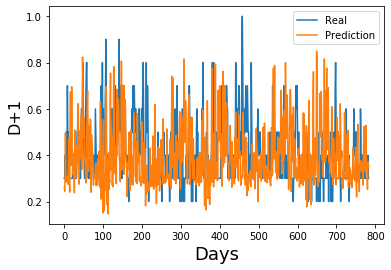

val_D1_loss 0.00136
val_D1_mean_absolute_error 0.02971
D1_loss 0.00067
D1_mean_absolute_error 0.0198


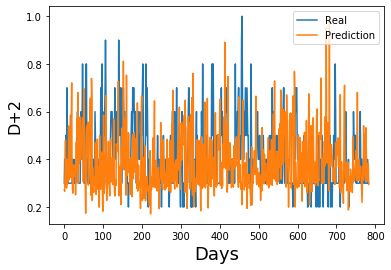

val_D2_loss 0.00114
val_D2_mean_absolute_error 0.02583
D2_loss 0.0007
D2_mean_absolute_error 0.02071


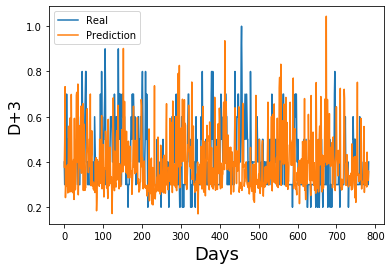

val_D3_loss 0.00155
val_D3_mean_absolute_error 0.03246
D3_loss 0.00074
D3_mean_absolute_error 0.02054


In [13]:
print('Prediction of the air index quality')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train_visual[:,plusDay], label='Real')
    plt.plot(y_pred_visual[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()
    for measureName in hist.history:
        if "D"+str(plusDay+1) in measureName:
            print(measureName,round(hist.history[measureName][-1],5))